<a href="https://colab.research.google.com/github/ryoiwata/neural_allstars/blob/main/all_stars/skyler/stringer_dataset_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title UMAP installation
# @markdown the order of these installations matters because Suit2p wants to downgrade numpy and this is not comptabile with the ARIMA package
!pip install umap-learn --quiet

In [ ]:
# @title Imports of UMAP, numpy, matplotlib, and data retrieval
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt
import os, requests



fname = "/content/drive/MyDrive/NMA Project Shared/stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)


/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [ ]:
# @title Load data into memory
dat = np.load(fname, allow_pickle=True).item()
sresp = dat['sresp']
pArea = dat['pupilArea']
beh_mask = dat['beh_svd_mask']
beh_time = dat['beh_svd_time']

print("keys are: ")
for key in dat.keys():
  print('\t',key)
print("response vector shape:", sresp.shape)
print("pupil vector shape:", pArea.shape)
print("beh_svd_mask vector shape:", beh_mask.shape)
print("beh_svd_time vector shape:", beh_time.shape)

keys are: 
	 sresp
	 run
	 beh_svd_time
	 beh_svd_mask
	 stat
	 pupilArea
	 pupilCOM
	 xyz
response vector shape: (11983, 7018)
pupil vector shape: (7018, 1)
beh_svd_mask vector shape: (240, 320, 1000)
beh_svd_time vector shape: (7018, 1000)


In [ ]:
# @title helper functions and libraries
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

def plot_activity(spike_data, num, *, win_length:int=500):
  assert type(win_length) != list

  num_subplots = num
  t_bin = 1.2
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = zscore(spike_data[:num_subplots], axis=1)
  fig, ax = plt.subplots(nrows=num_subplots, ncols=1, figsize=(8, num_subplots*1.5))
  for idx, activity in enumerate(subset):
    ax[idx].plot(np.arange(lower, upper), activity[lower:upper])
    ax[idx].set(title=f"zscored neuron index {idx}, over {span} mins")
  fig.show()


def plot_activity2(spike_data, num, *, win_length:int=500, sep:int = 5):
  assert type(win_length) != list

  t_bin = 1.2
  ticks = np.arange(0, num*sep , sep)
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  elif win_length == None:
    lower = 0
    upper = spike_data.shape[1]
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = zscore(spike_data[:num],axis=1)
  subset = subset + ticks[:, np.newaxis]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 11))
  ax.plot(np.arange(lower, upper), subset[:, lower:upper].T)
  ax.set_yticks(ticks)
  ax.set_yticklabels(np.arange(1,num+1))
  ax.set(title=f"plot of zscore {num} neurons from {(lower*1.2)/60:.2f} to {(upper*1.2)/60:.2f} mins")
  fig.show()


Text(0, 0.5, 'percent of explained variance')

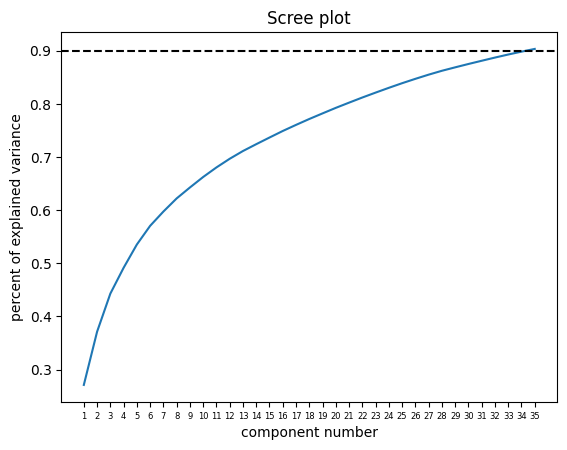

In [ ]:
# @title randomly select 100 neurons and perform PCA for top 90% components.
from sklearn.decomposition import PCA
top = 100
np.random.seed(1337)
random_indexes = np.random.choice(range(sresp.shape[0]),size=top, replace=False)
X = sresp[random_indexes,:]
pca = PCA(n_components=.9)
Y = pca.fit(X)
explained = Y.explained_variance_ratio_
fig = plt.figure()
ax = fig.gca()
ax.plot(np.cumsum(explained))
ax.axhline(.9, color='k', linestyle='--')
ax.set_title("Scree plot")
ax.set_xticks(np.arange(0,len(explained)))
ax.set_xticklabels(np.arange(1,len(explained)+1,), fontsize=6)
ax.set_xlabel("component number")
ax.set_ylabel("percent of explained variance")

In [ ]:
# @title view correlation between first `n` components
# rows = cols = 3 #set number of components t view
# fig, ax = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex= True, figsize=(rows*2.5,cols*2.5))
# for row in range(rows):
#     for col in range(cols):
#         ax[row,col].scatter(Y.components_[row,:], Y.components_[col,:], c='k', alpha=.8, s=.5)
#         ax[row,col].set_yticks([])
#         ax[row,col].set_xticks([])
#         ax[row,col].set_ylabel(f"pc{row}")
#         ax[row,col].set_xlabel(f"pc{col}")

From paper:
> at a scan rate of 3 or 2.5 Hz. For
three further recordings, we used single-plane
configuration, with a scan rate of 30 Hz.

`help(oasis)`
<details>
    oasis(F: numpy.ndarray, batch_size: int, tau: float, fs: float) -> numpy.ndarray
    computes non-negative deconvolution
    
    no sparsity constraints
    
    Parameters
    ----------------
    
    F : float, 2D array
        size [neurons x time], in pipeline uses neuropil-subtracted fluorescence
    
    batch_size : int
        number of frames processed per batch
    
    tau : float
        timescale of the sensor, used for the deconvolution kernel
    
    fs : float
        sampling rate per plane
    
    
    Returns
    ----------------
    
    S : float, 2D array
        size [neurons x time], deconvolved fluorescence
</details>

>One important problem is developing methods for spike detection: inferring the times of action potentials from the fluorescence traces. The earliest such methods rely on spike deconvolution algorithms, which infer a spike train **under the assumption that the fluorescence trace represents an approximate convolution of the underlying spike train with the cell's calcium response**

-- Pachitariu 2018

Additional preprocessing that may be done
> results, we excluded neurons whose signal might span two planes by excluding neurons
  in sequential planes that had a greater than a 0.6 correlation (in 1.2-s bins)
  with each other, and whose centers were within 5 mm of each other in XY.


In [ ]:
# @title DL Suit2p from Github; apply deconvolution; WARNING!! downgrades numpy
!pip install git+https://github.com/MouseLand/suite2p.git --quiet
from suite2p.extraction.dcnv import oasis

bs = 500
tau = 2.0 #timescale of sensor from paper, page 7.
fs = 30 #hz
smoothed = oasis(X, bs, tau, fs)

  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


NameError: ignored

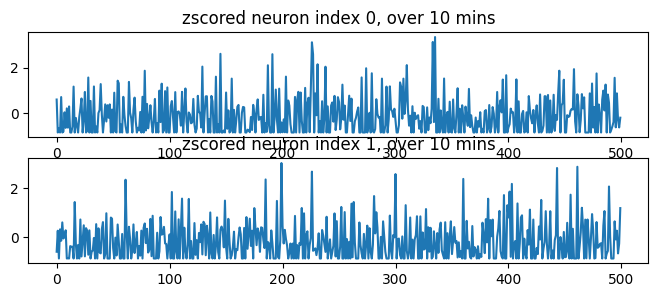

In [ ]:
# @title Before
num_neurons = 2 #@param {type:"raw"}

plot_activity(X, num_neurons)

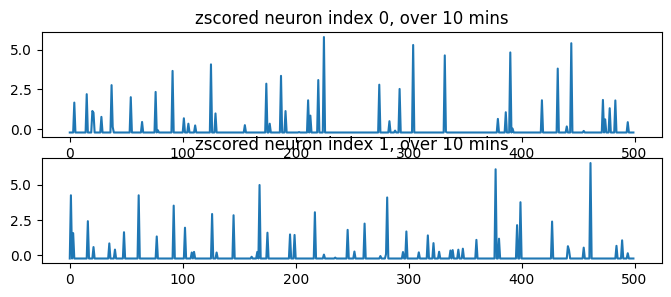

In [ ]:
# @title After
num_neurons = 2 #@param {type:"raw"}

plot_activity(smoothed, num_neurons)

# Does neural activity predict pupil size?

Let's compute simple statistics to see if there is a relationship between aggregate neuron activity and pupil are



In [ ]:
# do we have a statistic for each neuron?
# sum_stat = np.column_stack([sresp.mean(0), sresp.std(0), np.median(sresp,0)])
# res = np.linalg.lstsq(sum_stat, pArea)
# theta ,resi, _, _ = res
# sum_stat[:,0].shape
# labels = {0:"mean" ,1:"std", 2:"median"}
# nplots = len(theta)
# fig, ax = plt.subplots(1,3,sharey=True, figsize=(10,3))
# for col in range(nplots):
#   ax[col].scatter(theta[col]*sum_stat[:,col], pArea, color='k', s=.5, alpha=.8)
#   ax[col].set_title(f"pupil area vs. {labels[col]}")
# fig.supylabel('pupil area units^2')

In [ ]:
# find a smaller subset of neurons than 100
# pcaSubset = PCA(n_components=.9, whiten=True).fit_transform(X.T)
# # MSE
# theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)
# # look at how far off it is
# plt.scatter(pArea, pArea - pcaSubset @ theta, color='k', s=.5, alpha=.8)
# plt.title('residual plot of area and predicted area by top 39 PCs')
# plt.xlabel('actual pupil area')
# plt.ylabel('predicted pupil ')

In [ ]:
# repeat but with deconvolved data
# pcaSubset = PCA(n_components=.9, whiten=True).fit_transform(smoothed.T)

# theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)
# predicted = pArea - pcaSubset @ theta
# plt.scatter(pArea, predicted, color='k', s=.5, alpha=.8)
# plt.title('residual plot of area and predicted area by top 39 PCs deconvolved')
# plt.xlabel('actual pupil area')
# plt.ylabel('predicted pupil ')


# Does the layer predict pupil size?

This brings us to our main question.

(3, 11983)


<ipython-input-19-85bb85dfffd4>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


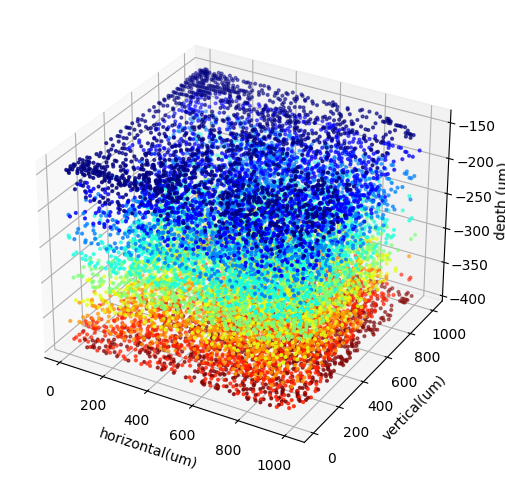

In [ ]:
# @title Are there different levels?
pos = dat['xyz']
print(pos.shape)
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = pos

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

In [ ]:
# @title Stratify our data set by their unqiue layer
from matplotlib import cm
pos = dat['xyz']

x, y, z = pos

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

layers, nueron_num = zunq.size, iunq.size
LAYER_KEY = dict(zip(zunq.astype(int), range(layers)))
print(f"there are {layers} different layers for the {nueron_num} nuerons")
# modify our dataset
sresp_mod = np.c_[dat['sresp'],iunq]

print("shape of old is ", sresp.shape)
print("shape of modified is ", sresp_mod.shape) #last column is our key column
def stratify(arr, layers):
  subarrays = list()
  for layer in range(layers):
    key = f"layer{layer+1}"
    idx = np.where(arr[...,-1] == layer)
    subarray = arr[idx]
    subarrays.append((key,subarray[...,:-1]))
  return dict(subarrays)

strat = stratify(sresp_mod, layers)

for layer in range(layers):
  key = f'layer{layer+1}'
  print(f"{key} has {strat[key].shape[0]} neurons")

<ipython-input-7-abef0388a09d>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


there are 9 different layers for the 11983 nuerons
shape of old is  (11983, 7018)
shape of modified is  (11983, 7019)
layer1 has 1386 neurons
layer2 has 1440 neurons
layer3 has 1418 neurons
layer4 has 1471 neurons
layer5 has 1415 neurons
layer6 has 1321 neurons
layer7 has 1218 neurons
layer8 has 1183 neurons
layer9 has 1131 neurons


In [ ]:
fpath2 = '/content/drive/MyDrive/NMA Project Shared/'
for layer in range(layers):
  key = f'layer{layer+1}'
  fname = key + '.csv'
  np.savetxt(os.path.join(fpath2, fname), strat[key], delimiter=',')

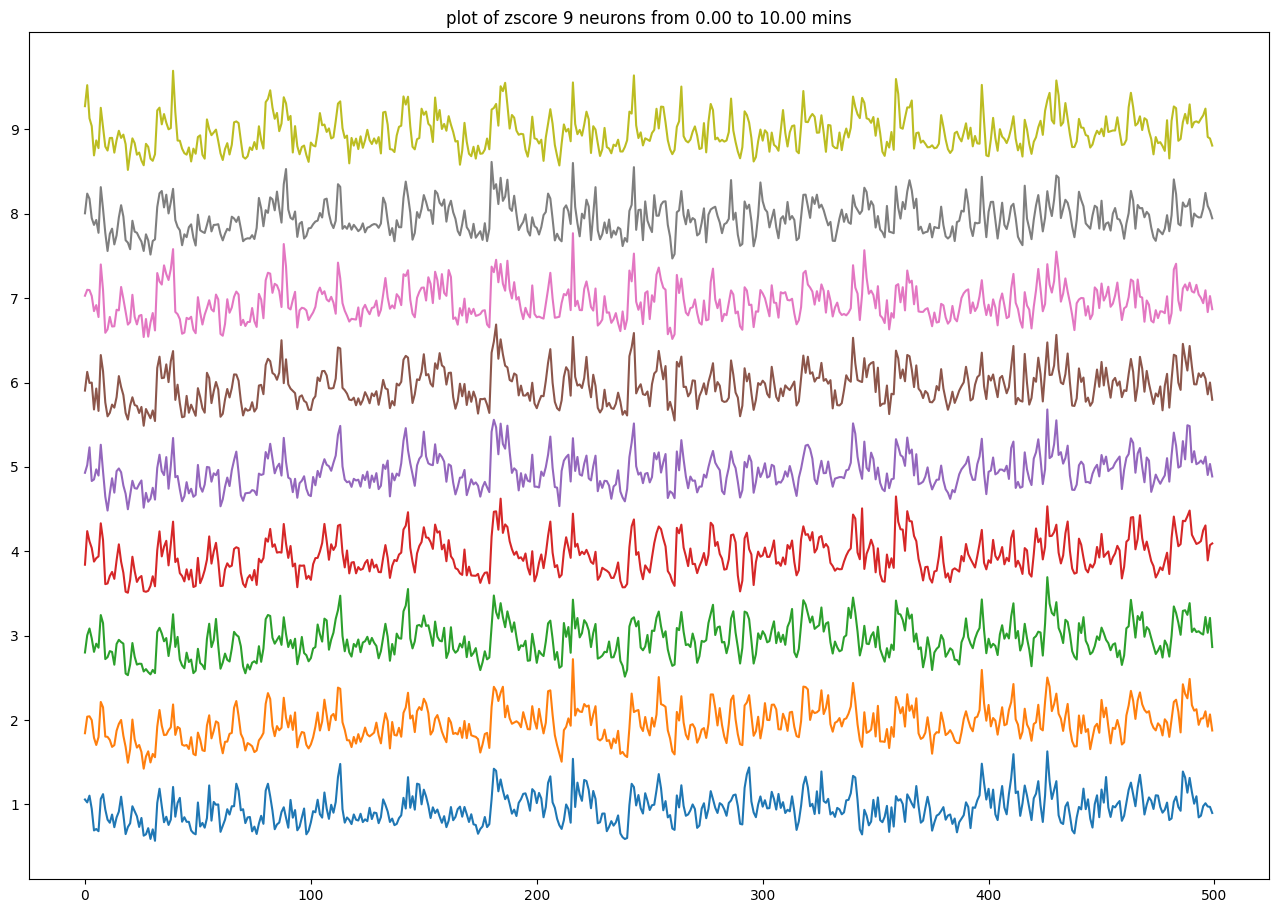

In [ ]:
# @title next let's view average activity per layer

avgs = list()
for layer in range(1,layers + 1, 1):
  avgs.append(np.mean(strat[f"layer{layer}"], 0))
avgs = np.row_stack(avgs)

# LOL THEY LOOK IDENTICAL HAHAAHAHAH
plot_activity2(avgs,layers)

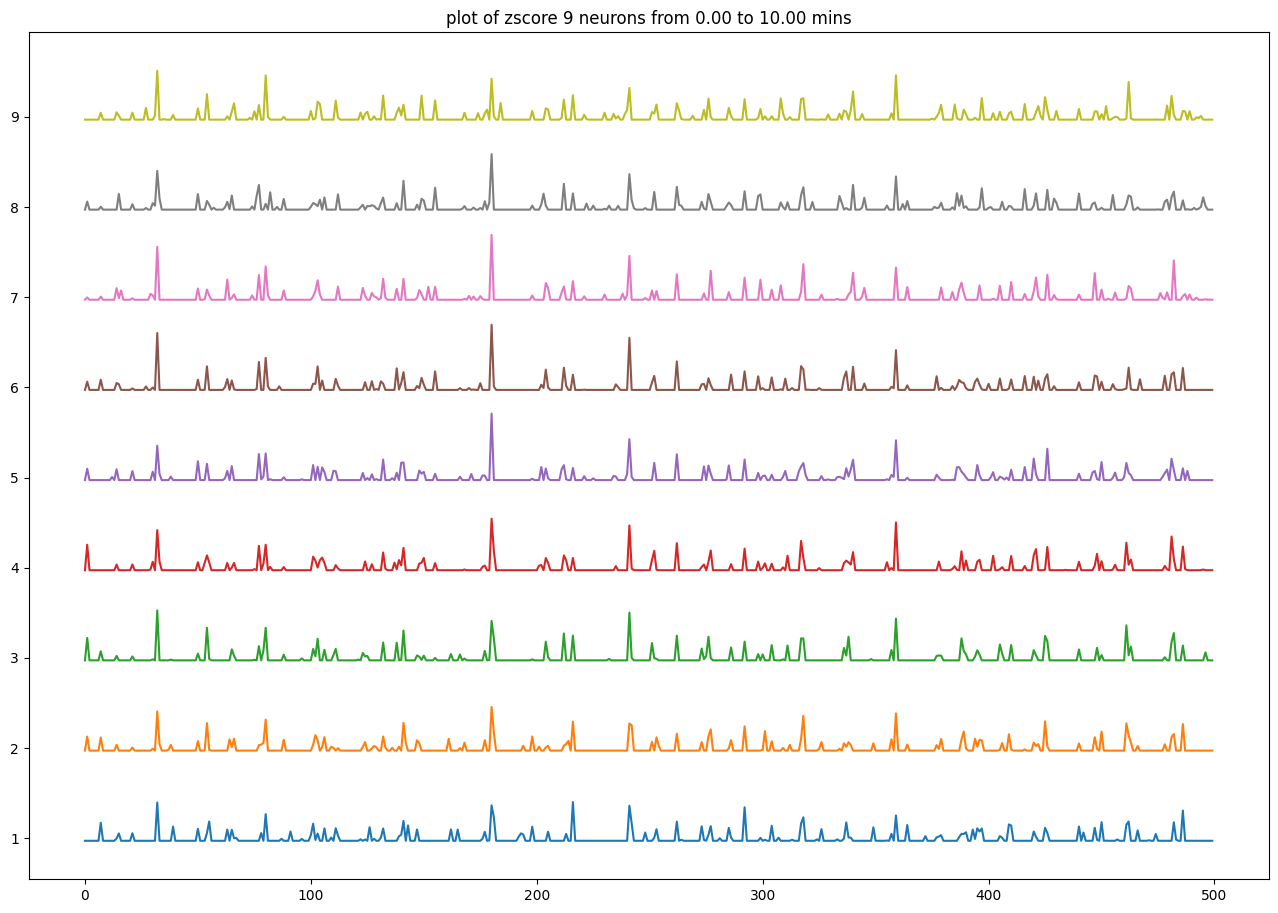

In [ ]:
# @title Slight differences between layers
# @markdown We can see that once they are deconvolved by layer there are slight differences but I don't know if the differences between these activity amounts are statistically significant.
avgs_smoo = oasis(avgs, bs, tau, fs)
plot_activity2(avgs_smoo,layers, sep=15)

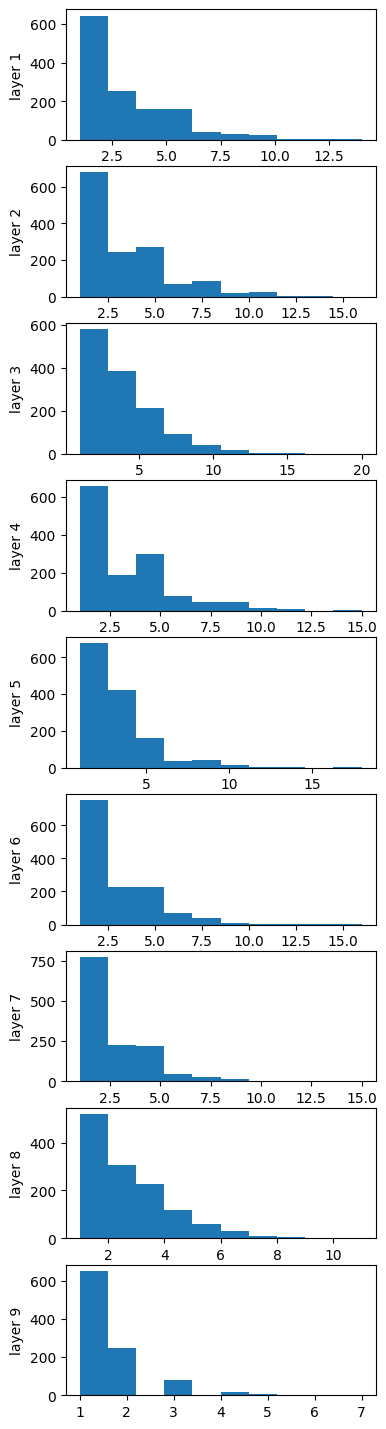

In [ ]:
# @title when looking at layer historgrams, we see: activity falls off with layers and poisson distribution
fig, ax = plt.subplots(nrows =layers, ncols=1,figsize=(4,18))

for i in range(layers):
  arr = avgs_smoo[i].astype(np.int32)
  ax[i].hist(np.delete(arr, arr== 0 ))
  ax[i].set(ylabel=f"layer {i+1}")

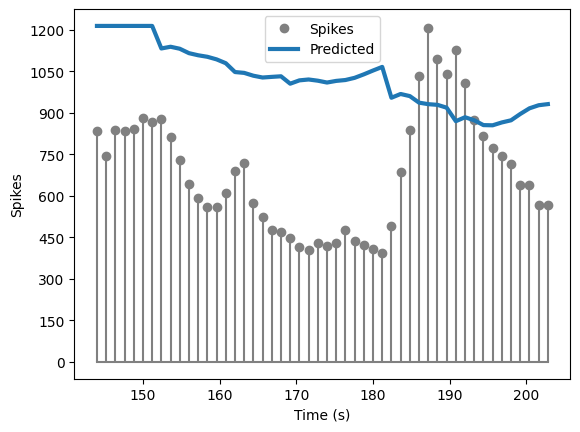

In [ ]:
# @title Let's do a poisson filter on each layer and see how it predicts spiking activity

# @markdown this is all boilerplat from W1D3
"""
design matrix time lag
we don't have stim intensity but we have neural activity a proxy
in this tutorial we used stimulus activity to model spiking activity
here we use spiking activity to model neural activity
we could ask some bayesian questions here too but that's beyond what I want to do with this section of code
"""

from scipy.optimize import minimize

def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  From week 1 day 3
  """

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])


  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t+d]

  return X


def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """

  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = (y.T @ np.log(rate)) - (np.ones_like(y).T @ rate)

  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """

  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim, d=d)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0 , args=(X, y))

  return res["x"]


def plot_spike_filter(theta, dt, show=True, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()
    show (boolean): To plt.show or not the plot.
  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()


def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    show (boolean): To plt.show or not the plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  plt.show()

def predict_spike_counts_lnp(stim, spikes, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """

  y = spikes
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(stim, d=d)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)
  yhat = np.exp(theta @ X.T)
  return yhat

D = 25
theta_lnp = fit_lnp(avgs_smoo[0,:], pArea, d=D)
dt_stim= 1.2
# plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")

# Predict spike counts
yhat = predict_spike_counts_lnp(avgs_smoo[0,:], pArea, theta_lnp, d=D)

# Visualize
plot_spikes_with_prediction(pArea, yhat, dt_stim)


# Layerwise polynomial prediction
It's clear that the Poisson temporal filter is not doing a good job at estimate the activity from the spikes. Next, I want to do a polynomial regression on a subset of the data in a single layer and see how well it does at modeling outside of our dataset. If it does well, I will try the same with a neural network.

In [ ]:
# @title PCA unaveraged data to smaller num of neurons.

pcas = list()
pca_model = PCA(n_components=.9)
for layer in range(layers):
  pcas.append(pca_model.fit_transform(np.transpose(strat[f"layer{layer+1}"])))

In [ ]:
import pickle
from pickle import HIGHEST_PROTOCOL

with open("/content/drive/MyDrive/NMA Project Shared/pcas_100_startified.pickle", 'wb') as f:
  pickle.dump(pcas,f, HIGHEST_PROTOCOL)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_reg = PolynomialFeatures(degree=2)
test = poly_reg.fit_transform(pcas[0], pArea)

In [ ]:
from sklearn.linear_model import LinearRegression

poly_reg_model = LinearRegression()
poly_reg_model.fit(test, pArea)

In [ ]:

#LinearRegression Fit
#Correlation

# Can pupil size as a time series be used to predict pupil size?

With smoothed data. We want to see if we can forecast the next steps in the sequence given the previous points in the sequence.

- Our data is likely stationary because the trends in the data are a function of the stimulus and not the time at which the stimulus was recorded.
- We try smoothing the data to see if that helps to emphasize the larger points and general trend and not the low changes between pupil sizes
- We also try differencing the data to see if that helps to emphasize the changes. This sometimes can also turn a non-stationary time series process into a stationary process

**TODO**
* Metric for measuring prediction of forecast
* Metric for measuing correlcation between fitted and baseline for ARIMA

In [ ]:
# @title Smooth out bumps in the plot by uniform 1d filter of Normalized data
nsubplots = 4
fig,ax = plt.subplots(nsubplots, 1, sharex=True, figsize =(21, 2*nsubplots))

#---- parameter changes -----
norm = (pArea/pArea.max())[:500]
shift = len(norm) // 100
filtered = uniform_filter1d(norm, shift, axis = 0, mode='constant', cval=1)
diff = np.diff(norm, axis = 0) #first difference
diff_smooth = np.diff(filtered, axis =0)
# tplots = [norm, filtered, differenced, differenced_smooth]
#---- plot changes -----
ax[0].plot(norm, color='red')
ax[0].set_title("raw data ")
ax[1].plot(filtered, color='blue')
ax[1].set_title("smoothed data")
ax[2].plot(diff, color='red')
ax[2].set_title("differences")
ax[3].plot(diff_smooth, color='blue')
ax[3].set_title("smoothed differences ")

In [ ]:
# @title for fun we can see what the smooth data looks like spectrographically
# @markdown this sort of shows us that big energy changes re concentrated in slower changes as opposed to faster ones.
nsubplots = 2
fig,ax = plt.subplots(1, nsubplots, sharey=True, figsize =(14, 2*nsubplots))
res = ax[0].specgram(x = diff.squeeze(), mode='psd')
ax[0].set_title('PSD of raw 1^o difference')
res = ax[1].specgram(x = diff_smooth.squeeze(), mode='psd')
ax[1].set_title('PSD of smoothed 1^o difference')

In [ ]:
# @title create ARIMA from previous 5 time points.
# @markdown in an AR model we are simply using past values to form a regression predicted the next time point.But instead of using the values at a time point $t$ we are using the errors $\epsilon$
from statsmodels.tsa.arima.model import ARIMA
model_rough = ARIMA(norm, order=(5,1,0))
model_smooth = ARIMA(filtered, order=(5,1,0))
model_fit_rough = model_rough.fit()
model_fit_smooth = model_smooth.fit()
print(model_fit_rough.summary())
print(model_fit_smooth.summary())

In [ ]:
# @title look at fitted values; might be overfitting, but does better job on the smoothed data
nsubplots = 2
fig,ax = plt.subplots(nsubplots, 1, sharex=True, figsize =(21, 2*nsubplots))
#---- parameter changes -----
ax[0].plot(norm, color='red', label="raw")
ax[0].plot(model_fit_rough.fittedvalues, color='blue', label='fitted values')
ax[0].set_title("fitted raw data vs raw data")
ax[1].plot(filtered, color='red')
ax[1].plot(model_fit_smooth.fittedvalues, color='blue', label='fitted values')
ax[1].set_title("fitted smooth data vs smoothed data")

In [ ]:
# @title Let's try out of sample data
# ------ hyperparameters
next_n_samples = 50 #@param {type:"raw"}
factor = 5
slide = factor * next_n_samples
# --- plotting things ------
nsubplots = 1
fig, ax = plt.subplots(nrows = nsubplots , ncols =1, sharex=True, figsize =(21, 4*nsubplots))
#---- out of sample of next 5 points in sequence
next_5_samples = pArea[500:500+slide+1]
rough_fcast = model_fit_rough.apply(next_5_samples)
smooth_fcast = model_fit_smooth.apply(next_5_samples)
ax.plot(next_5_samples, color='red', linewidth=3.0, linestyle='dotted', label="ground truth")
ax.plot(rough_fcast.fittedvalues, color='blue', linewidth = 1.5, linestyle='solid', label='fitted values')
ax.plot(smooth_fcast.fittedvalues, color='green',linewidth = 1.5,  linestyle='solid', label='smooth fitted values')
fig.suptitle(f"fitted forecast vs {next_n_samples} out of sample points", fontsize=16)
ax.legend()